## (Problem #2) Face Mask Detection: Given an image with a face of a person, you are expected to build a model that classifies whether that person is wearing a mask or not.

In [1]:
!pip install tensorflow
!pip install opencv-python
!pip install matplotlib
!pip install numpy

In [2]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

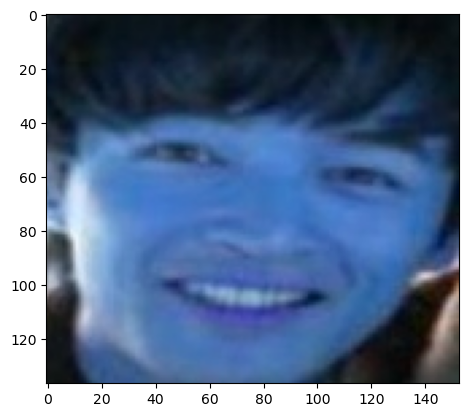

In [5]:
img_array = cv2.imread("face_mask_detection/data/without_mask/without_mask_1013.jpg")
plt.imshow(img_array) # BGR

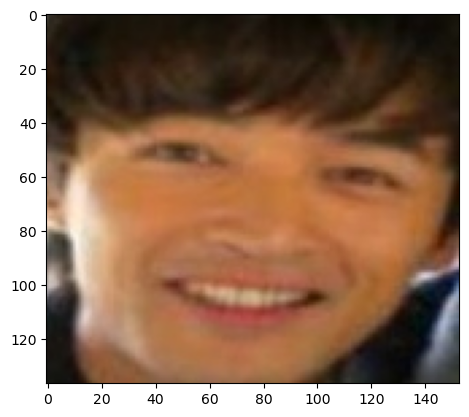

In [6]:
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)) # RGB

In [7]:
img_array.shape

(137, 153, 3)

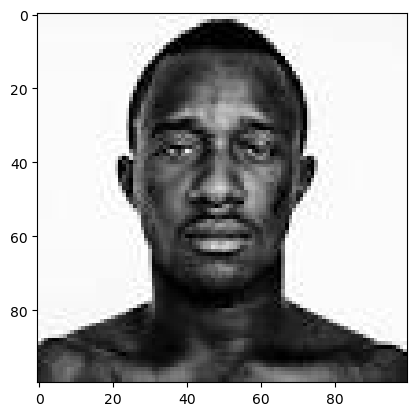

In [9]:
Datadirectory = "face_mask_detection/data/" 
Classes = ["without_mask", "with_mask"]
for category in Classes:
    path = os.path.join(Datadirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break
    

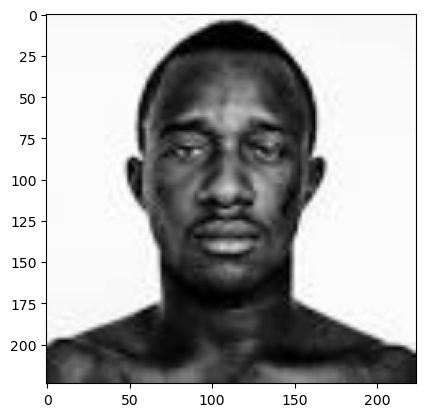

In [10]:
img_size = (224,224) # imageNet => 224x224

new_array = cv2.resize(img_array, img_size)
plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB))
plt.show()

**reading the images and converting all to array**

In [53]:
training_Data = []

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, img_size)
                training_Data.append([new_array, class_num])
            except Exception as e:
                pass

In [54]:
create_training_Data()

In [55]:
print(len(training_Data))

7553


In [56]:
import random
random.shuffle(training_Data)

In [57]:
x = [] # data
y = [] # label

for features, label in training_Data:
    x.append(features)
    y.append(label)


x = np.array(x)

In [58]:
x.shape

(7553, 224, 224, 3)

In [59]:
# normalize data
x = x/255.0

In [60]:
# save all changes
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [61]:
pickle_in = open("X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle", "rb")
y = pickle.load(pickle_in)

### deep learning model for training - Transfere Learning

In [62]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

In [63]:
# This will load the MobileNet model pre-trained on the ImageNet dataset and freeze all the layers
# except the top layer, which will be replaced with your own output layer.
model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [64]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

#### transfer learning - Tuning, weights will start from last check point 

In [65]:
base_input = model.layers[0].input

In [66]:
base_output = model.layers[-4].output

In [67]:
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(2)(Flat_layer)
final_output = layers.Activation("softmax")(final_output)

In [68]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [69]:
new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

### settings for binary classification (Face mask / without mask)

In [73]:
new_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [71]:
X = np.array(X)
y = np.array(y)

In [74]:
new_model.fit(X, y, epochs=2, validation_split=0.2)

Epoch 1/2
189/189 [==============================] - 370s 2s/step - loss: 0.3018 - accuracy: 0.9646 - val_loss: 4.5989 - val_accuracy: 0.9563
Epoch 2/2
189/189 [==============================] - 345s 2s/step - loss: 0.0408 - accuracy: 0.9906 - val_loss: 4.2339 - val_accuracy: 0.9563


In [75]:
new_model.save("my_model1.h5")

In [76]:
new_model = tf.keras.models.load_model("my_model1.h5")

### checking the model for prediction on unknown image (without mask predict 0, with mask predict 1)

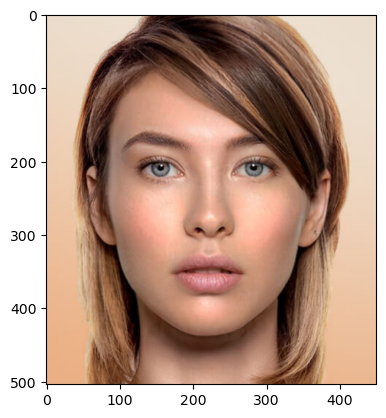

In [77]:
frame = cv2.imread('unknown_image_without_mask.jpeg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [78]:
final_image = cv2.resize(frame, img_size)
final_image = np.expand_dims(final_image, axis=0) # need fourth dimention
final_image = final_image/255.0

In [79]:
predictions = np.argmax(new_model.predict(final_image), axis=1)

1/1 [==============================] - 1s 620ms/step


In [80]:
predictions

array([0], dtype=int64)

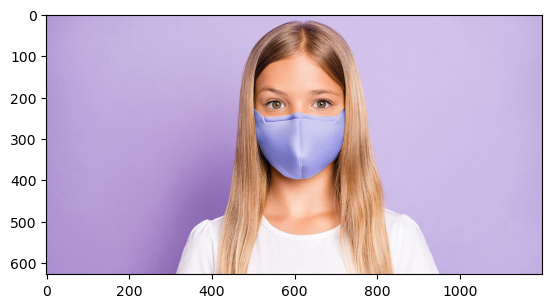

In [81]:
frame = cv2.imread('unknown_image_with_mask.jpeg')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [82]:
final_image = cv2.resize(frame, img_size)
final_image = np.expand_dims(final_image, axis=0) # need fourth dimention
final_image = final_image/255.0

In [83]:
predictions = np.argmax(new_model.predict(final_image), axis=1)

1/1 [==============================] - 0s 43ms/step


In [84]:
predictions

array([1], dtype=int64)